# Initialization

## 0. Imports

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt

## 1. Helper Functions

### 1a. Timestamp Conversions

In [2]:
# Convert a timestamp to unix seconds
def timestamp_to_unix_seconds(x):
    date_format = datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")
    unix_seconds = datetime.datetime.timestamp(date_format)
    return unix_seconds

# Convert a timestamp to unix milliseconds
def timestamp_to_unix_milliseconds(x):
    unix_seconds = timestamp_to_unix_seconds(x)
    unix_milliseconds = int(unix_seconds * 1000)
    return unix_milliseconds

### 1b. Pre-Processing EEG

In [3]:
# Preprocessing EEG
def read_muse(filename):
    # Read the raw eeg file
    df = pd.read_csv(filename)
    
    # Extract seconds from unix
    df['unix_sec'] = df['TimeStamp'].apply(timestamp_to_unix_seconds)
    df['unix_ms'] = df['TimeStamp'].apply(timestamp_to_unix_milliseconds)
    
    # Calculate relative seconds
    df['rel_sec'] = df['unix_sec'] - df['unix_sec'].iloc[0]
    df['rel_ms'] = df['unix_ms'] - df['unix_ms'].iloc[0]
    
    # separate blinks from raw data
    signals = df[df['Elements'].isna()]
    blinks = df[df['Elements']=='/muse/elements/blink']
    
    # Return blinks and signals
    return signals, blinks

# Separate columns, between raw and processed
def separate_eeg(df, time_colnames=['unix_sec','unix_ms', 'rel_sec', 'rel_ms']):
    raw_colnames = {
        'RAW_TP9':'TP9', 
        'RAW_TP10':'TP10', 
        'RAW_AF7':'AF7', 
        'RAW_AF8':'AF8'
    }
    processed_colnames = [
        'Delta_TP9','Delta_TP10','Delta_AF7','Delta_AF8',
        'Theta_TP9', 'Theta_TP10', 'Theta_AF7', 'Theta_AF8',
        'Alpha_TP9', 'Alpha_TP10', 'Alpha_AF7', 'Alpha_AF8',
        'Beta_TP9', 'Beta_TP10', 'Beta_AF7', 'Beta_AF8',
        'Gamma_TP9', 'Gamma_TP10', 'Gamma_AF7', 'Gamma_AF8'
    ]
    
    raw_df = df[
        [
            *time_colnames, 
            *list(raw_colnames.keys())
        ]
    ]
    raw_df.rename(columns=raw_colnames, inplace=True)
    
    processed_df = df[
        [
            *time_colnames,
            *processed_colnames
        ]
    ]
    
    """
    cleaned_df = df.drop(columns=[
        'Delta_TP9','Delta_TP10','Delta_AF7','Delta_AF8',
        'Theta_TP9', 'Theta_TP10', 'Theta_AF7', 'Theta_AF8',
        'Alpha_TP9', 'Alpha_TP10', 'Alpha_AF7', 'Alpha_AF8',
        'Beta_TP9', 'Beta_TP10', 'Beta_AF7', 'Beta_AF8',
        'Gamma_TP9', 'Gamma_TP10', 'Gamma_AF7', 'Gamma_AF8',
        'HSI_TP9','HSI_TP10', 'HSI_AF7', 'HSI_AF8',
        'AUX_LEFT', 'AUX_RIGHT',
        'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z',
        'Gyro_X', 'Gyro_Y', 'Gyro_Z',
        'PPG_Ambient', 'PPG_IR', "PPG_Red",
        'TimeStamp', 'HeadBandOn', 'Heart_Rate','Battery','Elements'
    ])
    cleaned_df.rename(columns={'RAW_TP9':'TP9', 'RAW_TP10':'TP10', 'RAW_AF7':'AF7', 'RAW_AF8':'AF8'}, inplace=True)
    """
    return raw_df, processed_df

### 1c. Plotting

In [4]:
def plot_eeg_with_blinks(
        eeg_signals_df, 
        eeg_blinks_df=None, 
        vr_blinks_df=None, 
        channels=['AF7','AF8','TP9','TP10'], 
        channel_colors=['red','green','lightblue','purple'],
        eeg_blink_color='black',
        vr_blink_color='blue',
        time_col='unix_ms', 
        figsize=(15,7.5) 
):
    
    # Define the plot
    fig, axes = plt.subplots(len(channels),1,figsize=figsize)

    # Plot each eeg channel
    for i in range(len(channels)):
        channel = channels[i]
        channel_color = channel_colors[i]
        eeg_signals_df.plot(x=time_col, y=channel, c=channel_color, ax=axes[i])

    # Blinks from EEG, if provided
    if eeg_blinks_df is not None:
        for xc in eeg_blinks_df[time_col].tolist():
            for i in range(len(channels)):
                axes[i].axvline(x=xc, color=eeg_blink_color, linestyle='-')

    # Blinks from VR
    if vr_blinks_df is not None:
        vr_blinks_samples = vr_blinks_df[vr_blinks_df['event']=='Overlap']
        for xc in vr_blinks_samples[time_col].tolist():
            for i in range(len(channels)):
                axes[i].axvline(x=xc, color=vr_blink_color, linestyle='-')
    
    plt.show()

## 2. Primitives

In [5]:
# Primitives
_DATA_DIR = 'data/p0/'
_EEG_CSV = 'eeg.csv'
_BLINK_CSV = 'blink.csv'

# Reading Data

## 1. Reading Blinks from VR

In [6]:
# Read the raw blink data
vr_blinks_filename = os.path.join(_DATA_DIR, _BLINK_CSV)
vr_blinks_df = pd.read_csv(vr_blinks_filename)

# Extract timestamp data
vr_blinks_df['TimeStamp'] = vr_blinks_df['unix_ms'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000))
vr_blinks_df["unix_ms"] = pd.to_numeric(vr_blinks_df["unix_ms"])

# Display
vr_blinks_df.head(10)

,unix_ms,frame,rel_timestamp,event,overlap_counter,TimeStamp
0,1758146961975,1,0.000000,Start,0,2025-09-17 18:09:21.975
1,1758146968549,4228,6.542058,Overlap,1,2025-09-17 18:09:28.549
2,1758146970750,5913,8.743770,Overlap,2,2025-09-17 18:09:30.750
3,1758146972952,7602,10.945460,Overlap,3,2025-09-17 18:09:32.952
4,1758146975155,9219,13.148070,Overlap,4,2025-09-17 18:09:35.155
5,1758146979155,12277,17.148360,End,4,2025-09-17 18:09:39.155


## 2. Reading EEG

In [7]:
# Get both blinsk and signals from raw EEG
eeg_filename = os.path.join(_DATA_DIR, _EEG_CSV)
eeg_signals_df, eeg_blinks_df = read_muse(eeg_filename)

# Clean the raw signals
raw_eeg_df, processed_eeg_df = separate_eeg(eeg_signals_df)

# Display the cleaned eeg
raw_eeg_df.head(10)

/var/folders/r7/zkk06b910nd7ysr86dhn0yqh0000gn/T/ipykernel_14783/343257179.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df.rename(columns=raw_colnames, inplace=True)


,unix_sec,unix_ms,rel_sec,rel_ms,TP9,TP10,AF7,AF8
1,1.758147e+09,1758146960702,0.005,5,810.69600,792.16120,892.08790,800.62270
2,1.758147e+09,1758146960702,0.005,5,913.84610,884.43225,959.37730,806.66670
3,1.758147e+09,1758146960703,0.006,6,813.91943,827.61900,759.92676,805.45790
4,1.758147e+09,1758146960704,0.007,7,705.53110,732.52747,737.36260,801.83150
5,1.758147e+09,1758146960704,0.007,7,785.71430,774.02930,926.33700,801.83150
6,1.758147e+09,1758146960704,0.007,7,908.60803,871.53845,965.42126,806.26373
7,1.758147e+09,1758146960705,0.008,8,847.36260,856.22710,762.74725,809.48720
8,1.758147e+09,1758146960705,0.008,8,710.36630,754.28570,599.15753,802.23444
9,1.758147e+09,1758146960706,0.009,9,739.37730,746.22710,813.11350,796.19050
10,1.758147e+09,1758146960707,0.010,10,879.59705,845.75090,883.62640,801.42860


## 3. Plotting EEG

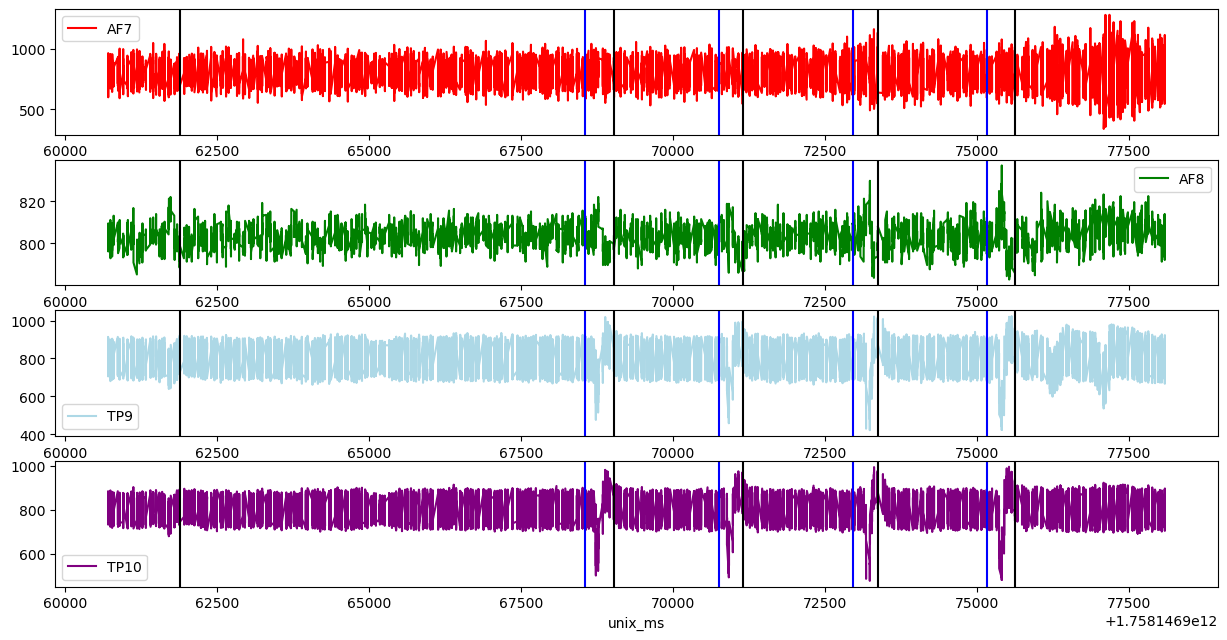

In [8]:
plot_eeg_with_blinks(raw_eeg_df, eeg_blinks_df, vr_blinks_df)

## 4. Exporting

In [9]:
raw_eeg_df_output_filename = os.path.join(_DATA_DIR, 'raw_eeg_df.csv')
processed_eeg_df_output_filename = os.path.join(_DATA_DIR, 'processed_eeg_df.csv')
eeg_blinks_df_output_filename = os.path.join(_DATA_DIR, 'eeg_blinks_df.csv')
vr_blinks_df_output_filename = os.path.join(_DATA_DIR, 'vr_blinks_df.csv')

raw_eeg_df.to_csv(raw_eeg_df_output_filename, index=False)
processed_eeg_df.to_csv(processed_eeg_df_output_filename, index=False)
eeg_blinks_df.to_csv(eeg_blinks_df_output_filename, index=False)
vr_blinks_df.to_csv(vr_blinks_df_output_filename, index=False)